# Visualizing the Decisions of the Interpretable CNN

In [1]:
import os
# Set the TensorFlow logging level to suppress debug messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm

from Training import TrainingScript
from Training.ModelFactory import plot_explanation_heatmap, get_explanation_heatmap_for_best_action, save_explanation_heatmap

In [2]:
def load_model(path: str):
    model = tf.keras.models.load_model(path, compile=False)
    model.compile()
    return model

In [3]:
model = load_model('./../../models/interpretable_cnn/breakout/started_at_2023-09-25_12-05-26/snapshot_final.keras')

C:\Users\timwi\anaconda3\envs\DeepReinforcementLearning\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: ModelFactory is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [4]:
env = TrainingScript.create_env("breakout")

In [5]:
state, _ = env.reset(seed=42)
list_of_states = []

for _ in tqdm(range(1000)):
    # model chooses action
    state = tf.cast(state, dtype=tf.float32) / 255.0
    state = tf.expand_dims(state, axis=0)
    q_values = model(state)
    action = tf.argmax(q_values, axis=1)
    action_item = action[0]

    old_state = state
    state, reward, terminated, truncated, _ = env.step(action_item)
    done = terminated or truncated
    if done:
        state, _ = env.reset()

    list_of_states.append((old_state, action, reward))

  0%|          | 0/1000 [00:00<?, ?it/s]

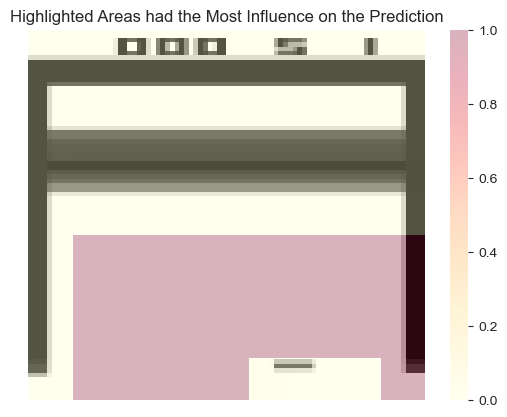

In [6]:
# Plot heatmap directly after start
sample = list_of_states[0][0]
heatmap = get_explanation_heatmap_for_best_action(model, sample)
plot_explanation_heatmap(sample, heatmap, vmin=0)

Found reward 1.0 for action [0]. INDEX=258


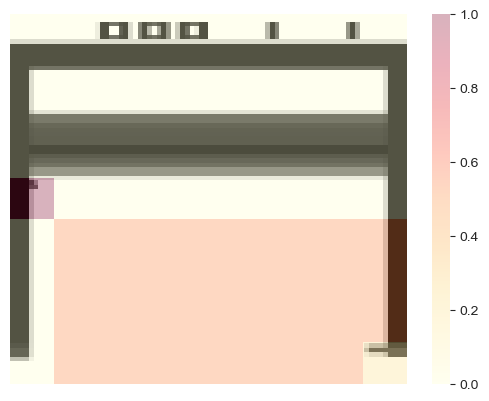

In [7]:
# Find action that lead to reward and plot heatmap for that action
frame_index = None
for idx, (state, action, reward) in enumerate(list_of_states):
    if reward > 0:
        print(f"Found reward {reward} for action {action}. INDEX={idx}")
        frame_index = idx
        heatmap = get_explanation_heatmap_for_best_action(model, state)
        title = None # f"Directly before receiving reward (Breakout)"
        plot_explanation_heatmap(state, heatmap, title=title)
        save_explanation_heatmap(state, heatmap, "./../../latex/plots/heatmaps/breakout_heatmap_before_reward.pdf", title=title)
        break

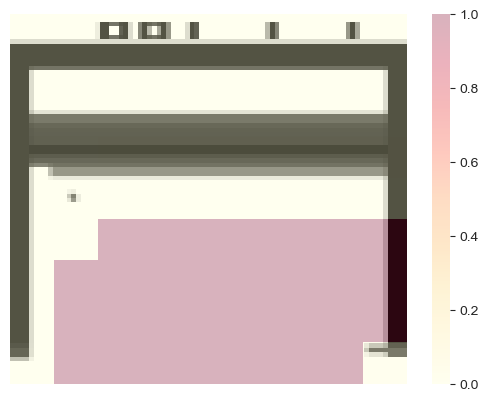

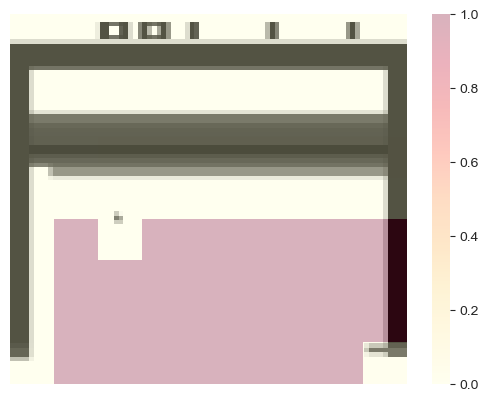

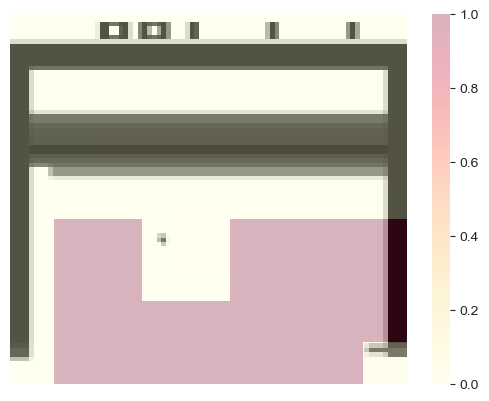

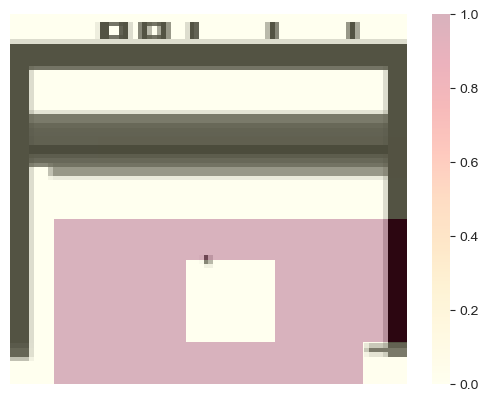

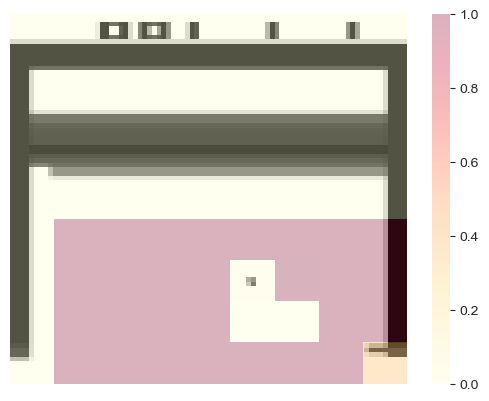

In [8]:
# Plot heatmaps directly after reward
for i in range(1, 6):
    state, action, reward = list_of_states[frame_index + (i*3)]
    heatmap = get_explanation_heatmap_for_best_action(model, state)
    title = None # f"{i*3} frames after receiving reward (Breakout)"
    plot_explanation_heatmap(state, heatmap, title=title)
    save_explanation_heatmap(state, heatmap, f"./../../latex/plots/heatmaps/breakout_heatmap_after_reward_{i*3}frames_after.pdf", title=title)

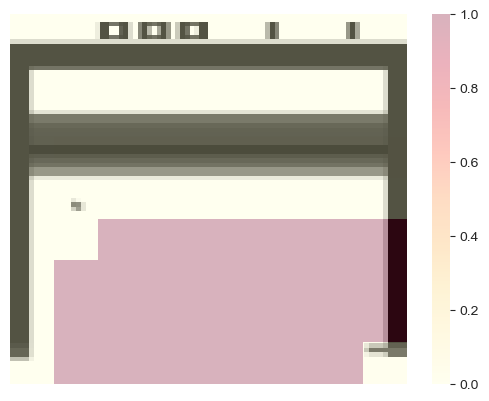

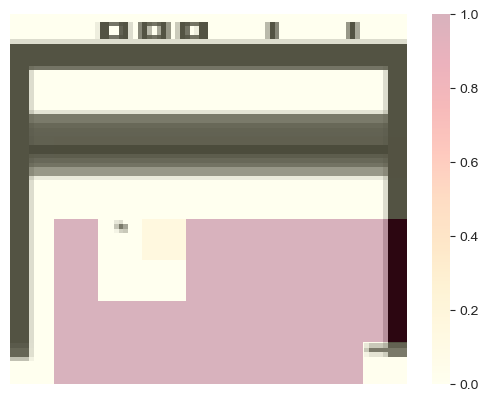

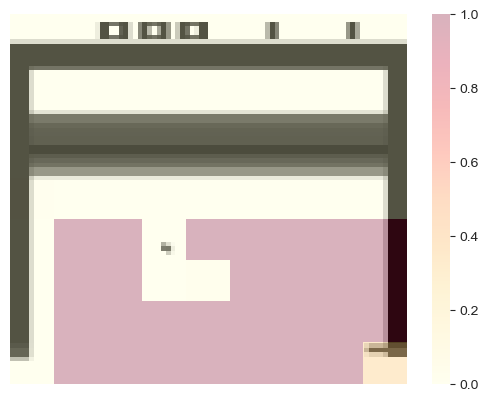

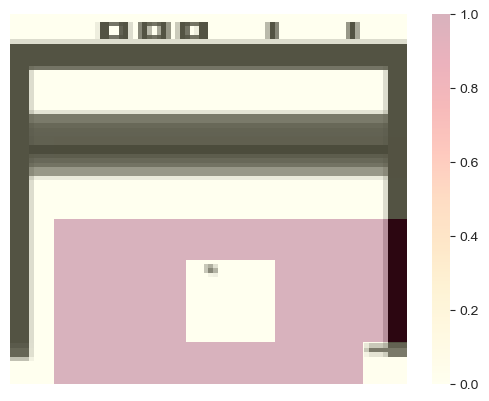

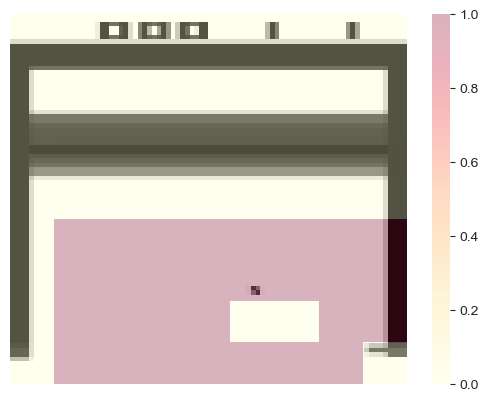

In [9]:
# Plot 10 frames before reward
for i in range(1, 6):
    state, action, reward = list_of_states[frame_index - (i * 3)]
    heatmap = get_explanation_heatmap_for_best_action(model, state)
    title = None # f"{i*3} frames before receiving reward (Breakout)"
    plot_explanation_heatmap(state, heatmap, title=title)
    save_explanation_heatmap(state, heatmap, f"./../../latex/plots/heatmaps/breakout_heatmap_before_reward_{i*3}frames_before.pdf", title=title)

## Plot comparing before training, half-way through training and after training

In [10]:
model_untrained = load_model("./../../models/interpretable_cnn/breakout/started_at_2023-09-25_12-05-26/snapshot_0.keras")
model_halfway1 = load_model("./../../models/interpretable_cnn/breakout/started_at_2023-09-25_12-05-26/snapshot_11.keras")
model_halfway2 = load_model("./../../models/interpretable_cnn/breakout/started_at_2023-09-25_12-05-26/snapshot_21.keras")
model_after_training = load_model("./../../models/interpretable_cnn/breakout/started_at_2023-09-25_12-05-26/snapshot_final.keras")

C:\Users\timwi\anaconda3\envs\DeepReinforcementLearning\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: ModelFactory is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Plot heatmaps directly before reward:

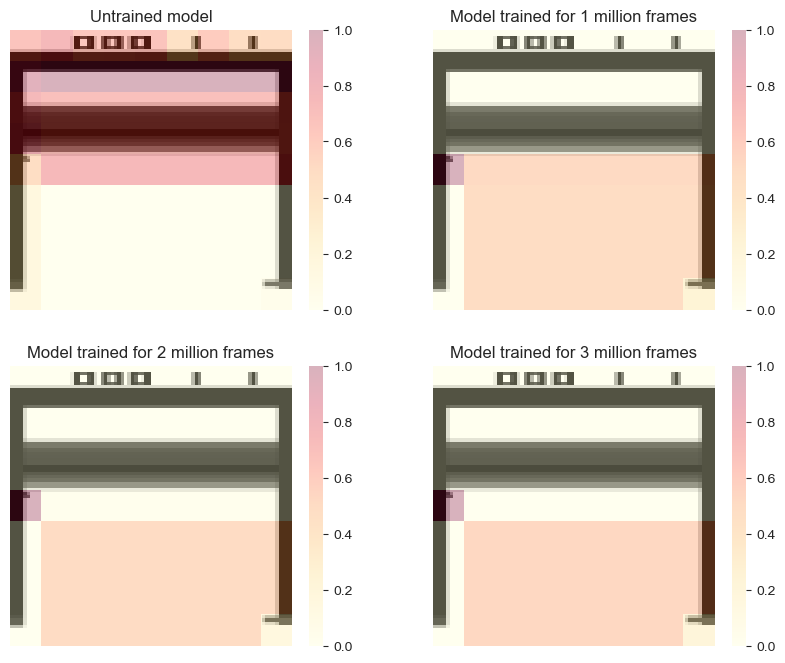

In [11]:
state, action, reward = list_of_states[frame_index]

heatmap_untrained = get_explanation_heatmap_for_best_action(model_untrained, state)
heatmap_halfway1 = get_explanation_heatmap_for_best_action(model_halfway1, state)
heatmap_halfway2 = get_explanation_heatmap_for_best_action(model_halfway2, state)
heatmap_after_training = get_explanation_heatmap_for_best_action(model_after_training, state)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(None) # 'Directly before receiving reward (Breakout)')

# Before training
sns.heatmap(heatmap_untrained, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax1)
ax1.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax1.get_aspect(),
              extent=ax1.get_xlim() + ax1.get_ylim(), zorder=1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Untrained model")

# Halfway through training
sns.heatmap(heatmap_halfway1, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax2)
ax2.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax2.get_aspect(),
              extent=ax2.get_xlim() + ax2.get_ylim(), zorder=1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Model trained for 1 million frames")

sns.heatmap(heatmap_halfway2, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax3)
ax3.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax3.get_aspect(),
              extent=ax3.get_xlim() + ax3.get_ylim(), zorder=1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title("Model trained for 2 million frames")


# After training
sns.heatmap(heatmap_after_training, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax4)
ax4.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax4.get_aspect(),
              extent=ax4.get_xlim() + ax4.get_ylim(), zorder=1)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title("Model trained for 3 million frames")

plt.savefig("./../../latex/plots/heatmaps/breakout_heatmap_training_comparison_before_reward.pdf", bbox_inches='tight')

# Plot heatmaps directly after reward:

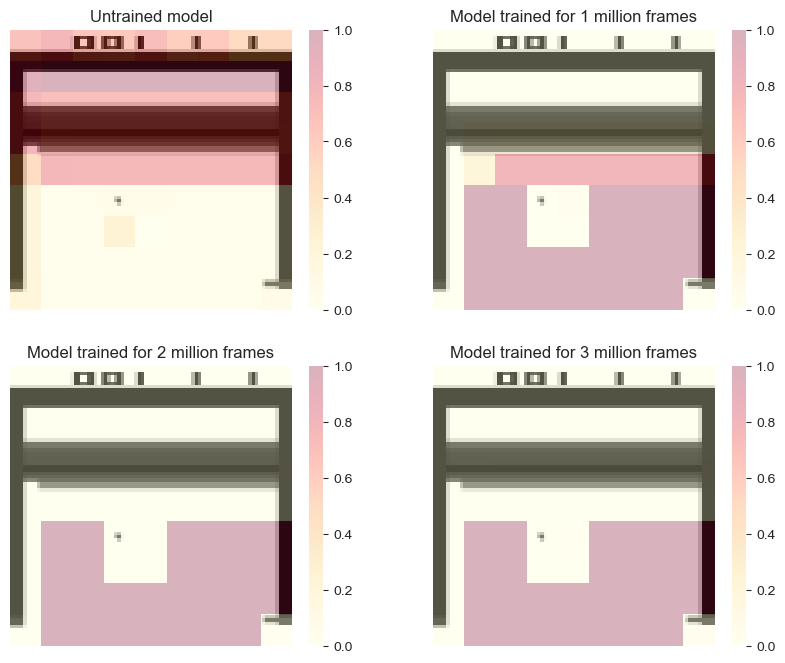

In [12]:
state, action, reward = list_of_states[frame_index+9]

heatmap_untrained = get_explanation_heatmap_for_best_action(model_untrained, state)
heatmap_halfway1 = get_explanation_heatmap_for_best_action(model_halfway1, state)
heatmap_halfway2 = get_explanation_heatmap_for_best_action(model_halfway2, state)
heatmap_after_training = get_explanation_heatmap_for_best_action(model_after_training, state)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(None) # '9 frames after receiving reward (Breakout)')

# Before training
sns.heatmap(heatmap_untrained, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax1)
ax1.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax1.get_aspect(),
              extent=ax1.get_xlim() + ax1.get_ylim(), zorder=1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Untrained model")

# Halfway through training
sns.heatmap(heatmap_halfway1, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax2)
ax2.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax2.get_aspect(),
              extent=ax2.get_xlim() + ax2.get_ylim(), zorder=1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Model trained for 1 million frames")

sns.heatmap(heatmap_halfway2, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax3)
ax3.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax3.get_aspect(),
              extent=ax3.get_xlim() + ax3.get_ylim(), zorder=1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title("Model trained for 2 million frames")


# After training
sns.heatmap(heatmap_after_training, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=ax4)
ax4.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=ax4.get_aspect(),
              extent=ax4.get_xlim() + ax4.get_ylim(), zorder=1)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title("Model trained for 3 million frames")

plt.savefig("./../../latex/plots/heatmaps/breakout_heatmap_training_comparison_after_reward.pdf", bbox_inches='tight')

Plot heatmaps for temporal comparison

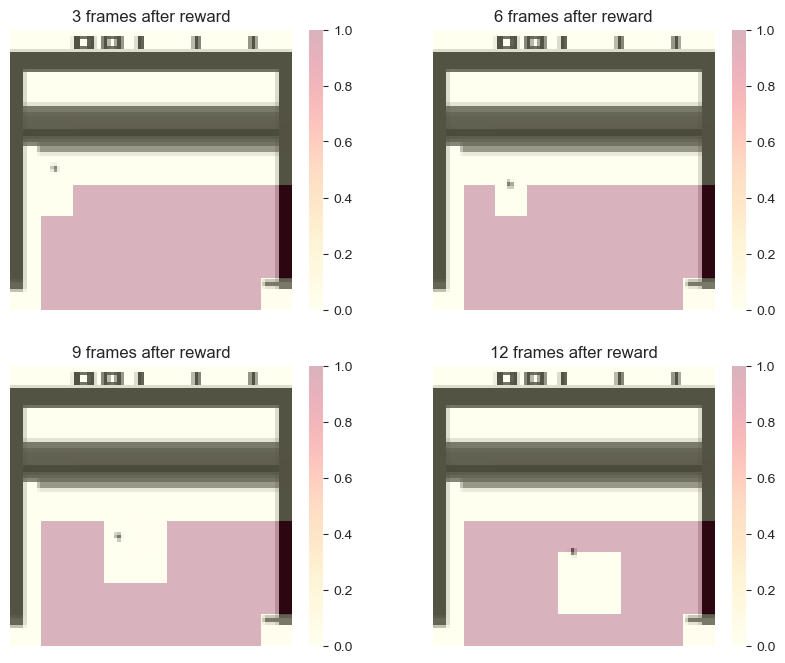

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(None) # 'Shortly after receiving reward (Breakout)')

for i in range(4):
    state, action, reward = list_of_states[frame_index + ((i+1) * 3)]
    heatmap = get_explanation_heatmap_for_best_action(model, state)
    current_ax = axes[i//2][i%2]

    sns.heatmap(heatmap, alpha=0.3, cmap=matplotlib.cm.YlOrRd, vmin=0, vmax=1, zorder=2, ax=current_ax)
    current_ax.imshow(state[0, -1, :, :], alpha=1, cmap=matplotlib.cm.binary, aspect=current_ax.get_aspect(),
                  extent=current_ax.get_xlim() + current_ax.get_ylim(), zorder=1)
    current_ax.set_xticks([])
    current_ax.set_yticks([])
    current_ax.set_title(f"{(i+1)*3} frames after reward")

plt.savefig("./../../latex/plots/heatmaps/breakout_heatmap_temporal_comparison_after_reward.pdf", bbox_inches='tight')